In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Summary of functions :**


*   Connection Graph 1 : GraphPlot(ee, layer = 1, riskname = riskname), this function could help plot the whole 50 bad actors with their corresponding transactional data, resulting plot will be stored in html file and could be downloaded to see in Google.


*   Connection Graph 2 : GraphSinglePlot, this function could help plot single bad actor with specific input bad actor name to see their corresponding transactional data, resulting plot will be stored in html file and could be saw in Google.


*   Connection Graph 3 : plotConnected, this function help plot a more detailed connection graph to one specific bad actor, it is highly possible that other bad actors will apeear in this specificed bad actor. This graph show direction of tranactions. Green node represents median risk level, red node represents high risk level, and other color represents low risk level. Also the number on the connection line represents the product of two customers' degree, high = 3, median = 2, low = 1.

*   For all three graphs, there is an important input called "layer". This input specified the degree of connection betwen transactions. Let us assume that customer "A" is one bad actor. Layer 1  will get all information of any customers having direct transactional relationship, such as "B". However, layer 1 will not get any other clients connects with "B". Layer 2 will help gather any client connected with both "A" and "B", then layer3, layer4......
You may find the rules.







In [87]:
try :
    from pyvis.network import Network
except :
    ! pip install pyvis
    from pyvis.network import Network
import networkx as nx
from pyvis.network import Network
from tqdm import tqdm
import time
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# from adjustText import adjust_text
from matplotlib.ticker import ScalarFormatter
# from fuzzywuzzy import fuzz
from tqdm import tqdm
import glob
import os

print('All done')

All done


# **Read and Prepare the Data**

In [8]:
edges = '/Users/zhuchenhao/Desktop/BigDataCompetition/UofT_edges.csv'
nodes = '/Users/zhuchenhao/Desktop/BigDataCompetition/UofT_nodes.csv'
risk = '/Users/zhuchenhao/Desktop/BigDataCompetition/UofT_occupation_risk.csv'
name = '/Users/zhuchenhao/Desktop/BigDataCompetition/targets.simple.csv'

'''
resultTable = bad actor list of Chenhao and Yuqi
resultTable2 = bad actor list of Jenny
'''
resultTable = pd.read_csv('/Users/zhuchenhao/Desktop/BigDataCompetition/result1.csv')
resultTable2 = pd.read_csv('/Users/zhuchenhao/Desktop/BigDataCompetition/badactor_foundin_kyc_bt_match.csv')
# resultTable.head()


edge = pd.read_csv(edges)
node = pd.read_csv(nodes)
risk = pd.read_csv(risk)
name = pd.read_csv(name)

In [9]:
resultTable2.RISK.value_counts()

high      30
medium     8
low        7
Name: RISK, dtype: int64

In [10]:
node.head(1)

,BIRTH_DT,CUST_ADD_DT,OCPTN_NM,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,PEP_FL,CASH_SUM_IN,CASH_CNT_IN,CASH_SUM_OUT,CASH_CNT_OUT,WIRES_SUM_IN,WIRES_CNT_IN,WIRES_SUM_OUT,WIRES_CNT_OUT,COUNTRY_RISK_INCOME,COUNTRY_RISK_RESIDENCY,RISK,NAME,GENDER,CUSTOMER_ID
0,1981-09-01,2007-07-05,89.0,1,1,0.0,2577.785,2.0,2851.663,7.0,70774.0,62.0,24244.0,35.0,Low,Low,low,"Young, Marie Mildren Coleman",Female,935382.0


In [11]:
edge.head(2)

,source,target,emt
0,983859.0,544485.0,503.807815
1,605618.0,362627.0,5157.568486


In [12]:
name1 = edge.source.unique().tolist()
name2 = edge.target.unique().tolist()
totalname = list(set(name1).union(set(name2)))
len(totalname)

361178

In [14]:
highrisk = node[(node.CUSTOMER_ID.isin(totalname))& (node.RISK == 'high')].CUSTOMER_ID.tolist()
# highrisk

In [15]:
resultTable.head(2)

,Unnamed: 0,BadActor,BadActor_Birth,Found_Name,Found_Name_Birth,Score
0,0,Golubev Alexander,1978-02-09,"Laxen, John Allender",1978-02-09,61
1,1,Nevelyn Gillies Willombe,1943-06-07,"Lucas, Wilma Geidl Neal",1943-06-07,61


In [16]:
resultTable2.head(2)

,Unnamed: 0,BIRTH_DT,CUST_ADD_DT,OCPTN_NM,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,PEP_FL,CASH_SUM_IN,CASH_CNT_IN,CASH_SUM_OUT,...,WIRES_SUM_IN,WIRES_CNT_IN,WIRES_SUM_OUT,WIRES_CNT_OUT,COUNTRY_RISK_INCOME,COUNTRY_RISK_RESIDENCY,RISK,NAME,GENDER,CUSTOMER_ID
0,123367,1963-07-06,1986-06-27,89.0,1,1,0.0,2408.782,1.0,27872.0,...,796375.0,35.0,218559.0,34.0,Low,Low,high,Jose Benito Cabrera Cuevas,Male,917730.0
1,125672,1965-03-07,2001-10-08,89.0,1,1,0.0,60348.480,31.0,30091.0,...,7049310.0,152.0,3055463.0,257.0,Low,Low,high,Alison Merrilla Redford,Female,359412.0


In [17]:
foundname = resultTable[resultTable.Score > 90].Found_Name.tolist()
# foundname = resultTable2.NAME.tolist()
foundname #= ['Michael Long']

['Zheynova, Marina Nikolaevna',
 'Trinidad Y Ramirez, Angelo',
 'Tetiana Viktorivna Pereverzeva',
 'Samantha Lewthwaite',
 'Poklonskaya, Natalija Vladimirovna',
 'Paul Franklin Watson',
 'Hlaing, Min Aung',
 'Alexey Alexeyevich Gromov',
 'Bezrukov, Sergey Vitalyevich',
 'O Jong Gil',
 'Rakhim Azizboevich Azimov',
 'Tsertsel, Ivan Stanislavavich']

**Combine the part1 name to a badactor list**

In [18]:
jennylist = resultTable2.NAME.tolist()
rogerlist = resultTable[resultTable.Score >= 80].Found_Name.tolist()
benbenlist = ['Smirnova, Natalia', 'Kelley, Christopher', 'Alison Merrilla Redford', 'Brenda Pope', 'Cesar Duarte Jaquez',
                'David Miller Moreno', 'Harrell, Ryan Matson Johnson', 'Leonid I. Kalaschnikow',  'David Myers',
              'Harrell, Ryan Matson Johnson', 'Brenda Pope', 'Nicholas Elliott', 'Michael Long']

badactor = list(set(jennylist).union(set(rogerlist)).union(set(benbenlist)))
len(badactor)

50

In [ ]:
badactor

In [19]:
bad = node[(node.NAME.isin(badactor))].reset_index(drop = True)
bad[['NAME', 'CUSTOMER_ID']]
#.to_csv('/content/drive/MyDrive/BIGdata/badActor_version1.csv')#[['RISK', 'NAME', 'CUSTOMER_ID']]

,NAME,CUSTOMER_ID
0,"Carlson, Jack",267189.0
1,Jose Benito Cabrera Cuevas,917730.0
2,Alison Merrilla Redford,359412.0
3,"Zheynova, Marina Nikolaevna",763368.0
4,"Mazhuga, Aleksandr G.",404022.0
...,...,...
57,Yon Jun Jo,659167.0
58,Viktor Petrovitsj Ivanov,165089.0
59,Rakhim Azizboevich Azimov,479020.0
60,Cesar Duarte Jaquez,979769.0


**Group by to reshape the data**

In [20]:
name_rule = dict(zip(bad.CUSTOMER_ID, bad.NAME))
risk = node[(node.NAME.isin(badactor))].CUSTOMER_ID.tolist()
riskname = node[(node.NAME.isin(badactor))].NAME.tolist()
ee = edge.groupby(by = ['source', 'target']).sum()
ee = ee.reset_index()
ee
# ee[ee.emt > 6600]

,source,target,emt
0,7.0,69883.0,509.911692
1,7.0,314999.0,2984.836484
2,7.0,980973.0,4984.327973
3,11.0,876639.0,2910.499409
4,25.0,579365.0,311.526741
...,...,...,...
466228,1000672.0,14024.0,114.625882
466229,1000673.0,295624.0,161.419638
466230,1000674.0,595097.0,1479.290194
466231,1000674.0,637931.0,2997.529483


In [73]:
ee.emt.describe()

count    466233.000000
mean       1080.340028
std        1305.276141
min          56.912763
25%         155.783331
50%         393.821975
75%        1516.447882
max        5394.814418
Name: emt, dtype: float64

In [21]:
layer = 2
EE = ee.replace({"source" : name_rule,
                    'target' : name_rule})
for i in range(layer) :
    ee2 = EE[(ee.source.isin(riskname)) | (EE.target.isin(riskname))]
    s = ee2.source.unique().tolist()
    t = ee2.target.unique().tolist()
    riskname = list(set(s).union(set(t)))

In [22]:
# ee2[ee2.emt > 3019]
ee

,source,target,emt
0,7.0,69883.0,509.911692
1,7.0,314999.0,2984.836484
2,7.0,980973.0,4984.327973
3,11.0,876639.0,2910.499409
4,25.0,579365.0,311.526741
...,...,...,...
466228,1000672.0,14024.0,114.625882
466229,1000673.0,295624.0,161.419638
466230,1000674.0,595097.0,1479.290194
466231,1000674.0,637931.0,2997.529483


# **Define two functions to plot the connection Graph between clients with transactional data**

In [74]:
# from IPython.core.inputtransformer2 import ESC_QUOTE2

def GraphPlot(ee, layer = 1, riskname = riskname) :
    '''
    GraphPlot function accept input : 
    ee as a dataframe, layer as how many layers of connection we used for plotting, riskname as clients' ID
    output a connection graph as html
    '''
    EE = ee.replace({"source" : name_rule,
                    'target' : name_rule})
    
    for i in range(layer) :
        ee2 = EE[(ee.source.isin(riskname)) | (EE.target.isin(riskname))]
        s = ee2.source.unique().tolist()
        t = ee2.target.unique().tolist()
        riskname = list(set(s).union(set(t)))

    rules = ee2[ee2.emt > 1516]
    rules["desc.x"] = rules["source"].astype(str)
    rules["desc.y"] = rules["target"].astype(str)
    G = nx.from_pandas_edgelist(rules, source = "desc.x", 
                                target = "desc.y", 
                                edge_attr = "emt")


    net = Network(notebook = True, width="80%", height=800
                , bgcolor="#222222", font_color="white"
                ,cdn_resources='remote', 
                select_menu=True, filter_menu=True)#
    net.from_nx(G)
    net.show_buttons(filter_=['physics'])
    net.show(f'Graph_{layer}th_layer.html')


GraphPlot(ee, layer = 10, riskname = riskname)

Graph_10th_layer.html


<ipython-input-74-bd83e5e2e890>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rules["desc.x"] = rules["source"].astype(str)
<ipython-input-74-bd83e5e2e890>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rules["desc.y"] = rules["target"].astype(str)


In [14]:
def GraphSinglePlot(ee, layer = 1, riskname = riskname) :
    aname = riskname[0]
    '''
    GraphSinglePlot function accept input : 
    ee as a dataframe, layer as how many layers of connection we used for plotting, riskname as clients' ID
    output a connection graph as html
    '''
    EE = ee.replace({"source" : name_rule,
                    'target' : name_rule})
    
    # print(EE.shape)
    
    for i in range(layer) :
        ee2 = EE[(ee.source.isin(riskname)) | (EE.target.isin(riskname))]
        s = ee2.source.unique().tolist()
        t = ee2.target.unique().tolist()
        riskname = list(set(s).union(set(t)))

    
    rules = ee2
    print(rules.shape)
    rules["desc.x"] = rules["source"].astype(str)
    rules["desc.y"] = rules["target"].astype(str)
    G = nx.from_pandas_edgelist(rules, source = "desc.x", 
                                target = "desc.y", 
                                edge_attr = "emt")


    net = Network(notebook = True, width="80%", height=800
                , bgcolor="#222222", font_color="white"
                ,cdn_resources='remote', 
                select_menu=True, filter_menu=True)#
    net.from_nx(G)
    net.show_buttons(filter_=['physics'])
    net.show(f'{aname}_Graph_{layer}th_layer.html')


GraphSinglePlot(ee, layer = 3, riskname = ['Alison Merrilla Redford'])

(133, 3)
Alison Merrilla Redford_Graph_3th_layer.html


<ipython-input-14-8d0b2bbfda4e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rules["desc.x"] = rules["source"].astype(str)
<ipython-input-14-8d0b2bbfda4e>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rules["desc.y"] = rules["target"].astype(str)


In [ ]:
node[node.NAME == 'Alison Merrilla Redford'].CUSTOMER_ID.values[0]

359412.0

In [ ]:
# EE = ee.replace({"source" : name_rule,
#                     'target' : name_rule})
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pylab


def plotConnected(ee, node, mode, riskname, layer = 2) : 
    '''
    input : ee as dataframe, node as original big clien dataframe, riskname = [target client name], layer = number of layer for transactional data
    '''

    EE = ee.copy()
    risk_rule = {'high' : 3, 'medium' : 2, 'low' : 1}
    # riskname = ['Alison Merrilla Redford']
    riskname1 = [node[node.NAME == riskname[0]].CUSTOMER_ID.values[0]]
    # find first layer connection in transactinoal data
    # ee2 = EE[(ee.source.isin(riskname1)) | (EE.target.isin(riskname1))]
    for i in range(layer) :
        ee3 = EE[(ee.source.isin(riskname1)) | (EE.target.isin(riskname1))]
        s = ee3.source.unique().tolist()
        t = ee3.target.unique().tolist()
        riskname1 = list(set(s).union(set(t)))

    right_table = node[['CUSTOMER_ID', 'RISK']]
    ee3 = ee3.merge(right_table, left_on='source', right_on = 'CUSTOMER_ID', how='left')
    ee3 = ee3.rename(columns = {'RISK' : 'source_risk'}).drop(['CUSTOMER_ID'], axis = 1)
    ee3 = ee3.merge(right_table, left_on='target', right_on = 'CUSTOMER_ID', how='left')
    ee3 = ee3.rename(columns = {'RISK' : 'target_risk'}).drop(['CUSTOMER_ID'], axis = 1)
    ee3 = ee3.replace({"source" : name_rule,
                        'target' : name_rule,
                    'source_risk' : risk_rule,
                    'target_risk' : risk_rule})
    ee3['weight'] = ee3.source_risk * ee3.target_risk
    lowlow = ee3[ee3.weight == 1].reset_index(drop = True)
    medianmedian = ee3[ee3.weight == 4].reset_index(drop = True)
    highhigh = ee3[ee3.weight == 9].reset_index(drop = True)
    medianhigh = ee3[ee3.weight == 6].reset_index(drop = True)
    lowhigh = ee3[ee3.weight == 3].reset_index(drop = True)
    lowmedian = ee3[ee3.weight == 2].reset_index(drop = True)

    # G = nx.DiGraph(directed=True)
    plt.figure(figsize = (25, 18))
    G = nx.DiGraph()
    if mode == 'medianhigh' :
        G.add_edges_from(list(zip(medianhigh.source, medianhigh.target)), weight=6)
    elif mode == 'highhigh' :
        G.add_edges_from(list(zip(highhigh.source, highhigh.target)), weight=9)
    elif mode == 'lowhigh' :
        G.add_edges_from(list(zip(lowhigh.source, lowhigh.target)), weight=3)
    elif mode == 'lowmedian' :
        G.add_edges_from(list(zip(lowmedian.source, lowmedian.target)), weight=2)
    elif mode == 'lowlow' :
        G.add_edges_from(list(zip(lowlow.source, lowlow.target)), weight=1)
    elif mode == 'medianmedian' :
        G.add_edges_from(list(zip(medianmedian.source, medianmedian.target)), weight=4)
    else :
        G.add_edges_from(list(zip(medianmedian.source, medianmedian.target)), weight=4)
        G.add_edges_from(list(zip(lowlow.source, lowlow.target)), weight=1)
        G.add_edges_from(list(zip(lowmedian.source, lowmedian.target)), weight=2)
        G.add_edges_from(list(zip(lowhigh.source, lowhigh.target)), weight=3)
        G.add_edges_from(list(zip(highhigh.source, highhigh.target)), weight=9)
        G.add_edges_from(list(zip(medianhigh.source, medianhigh.target)), weight=6)

    
    color_map = []
    for n in G:
        try : 
            if ee3[ee3.source == n].source_risk.values[0] == 1:
                color_map.append('blue')
            elif ee3[ee3.source == n].source_risk.values[0] == 2: 
                color_map.append('green')
            else :
                color_map.append('red')    
        except :
            if ee3[ee3.target == n].target_risk.values[0] == 1:
                color_map.append('blue')
            elif ee3[ee3.target == n].target_risk.values[0] == 2:
                color_map.append('green')
            else: 
                color_map.append('red')
    # val_map = {'A': 1.0,
    #                    'D': 0.5714285714285714,
    #                               'H': 0.0}

    # values = [val_map.get(node, 0.45) for node in G.nodes()]
    edge_labels=dict([((u,v,),d['weight'])
                    for u,v,d in G.edges(data=True)])
    # red_edges = [('C','D'),('D','A')]
    # edge_colors = ['black' if not edge in red_edges else 'red' for edge in G.edges()]

    pos = nx.spring_layout(G)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)#,
    nx.draw(G, pos, node_size=1500, edge_cmap=plt.cm.Reds, with_labels = True, node_color=color_map) #, edge_color=edge_colors, node_color = values
    plt.savefig(f'{riskname[0]}.png')
    pylab.show()



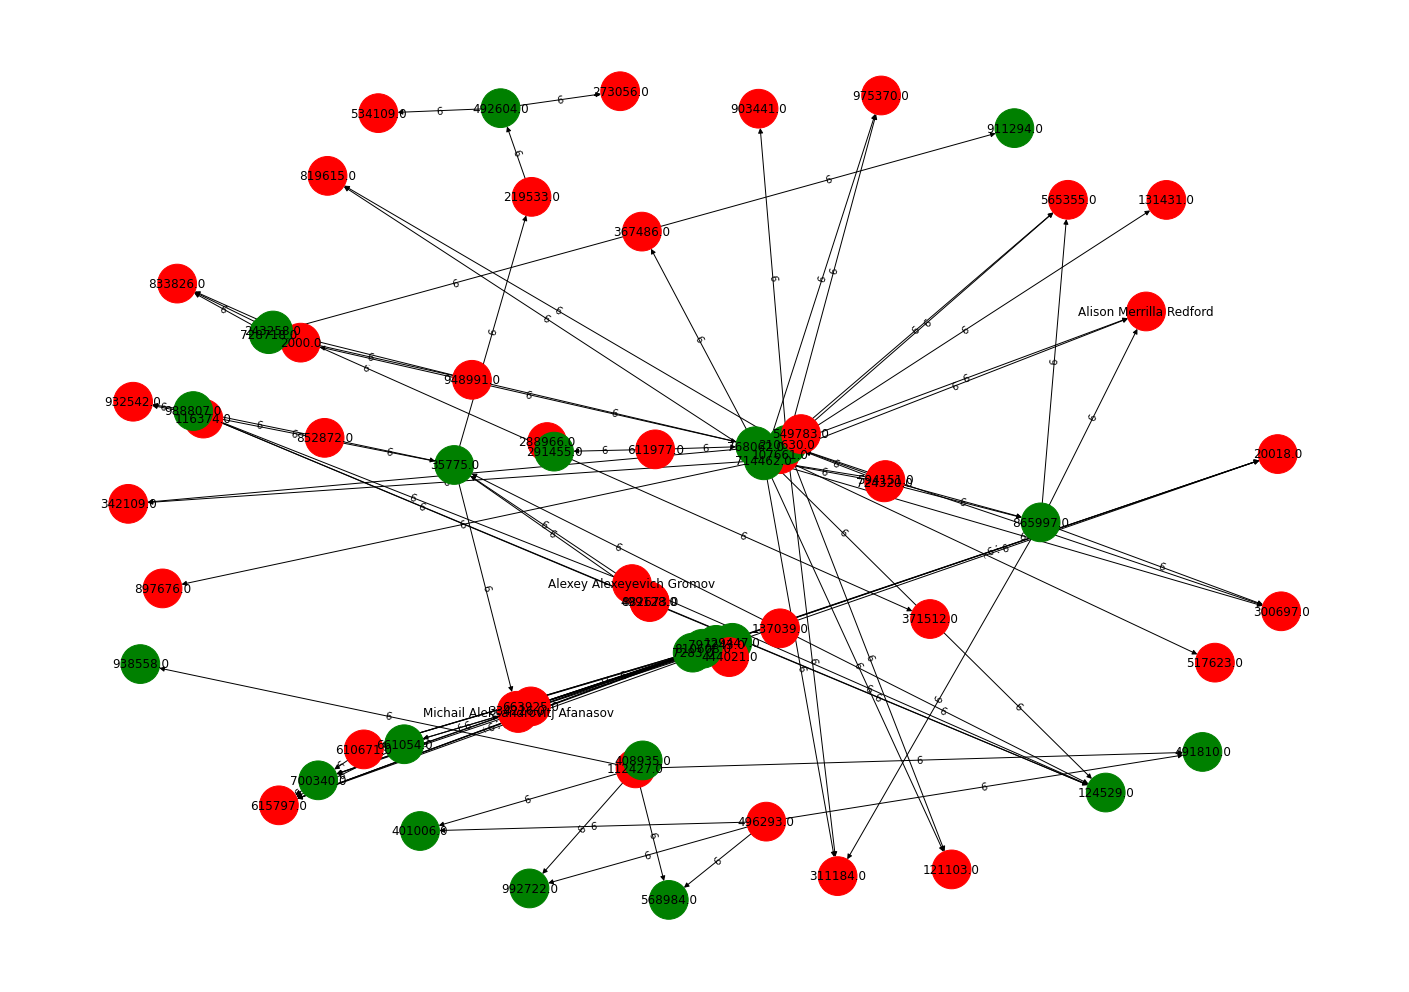

In [ ]:
# riskname = ['Alison Merrilla Redford']
riskname = ['Alexey Alexeyevich Gromov']
# riskname = ['O Jong Gil']
mode = 'medianhigh'
plotConnected(ee, node, mode, riskname, layer = 4)

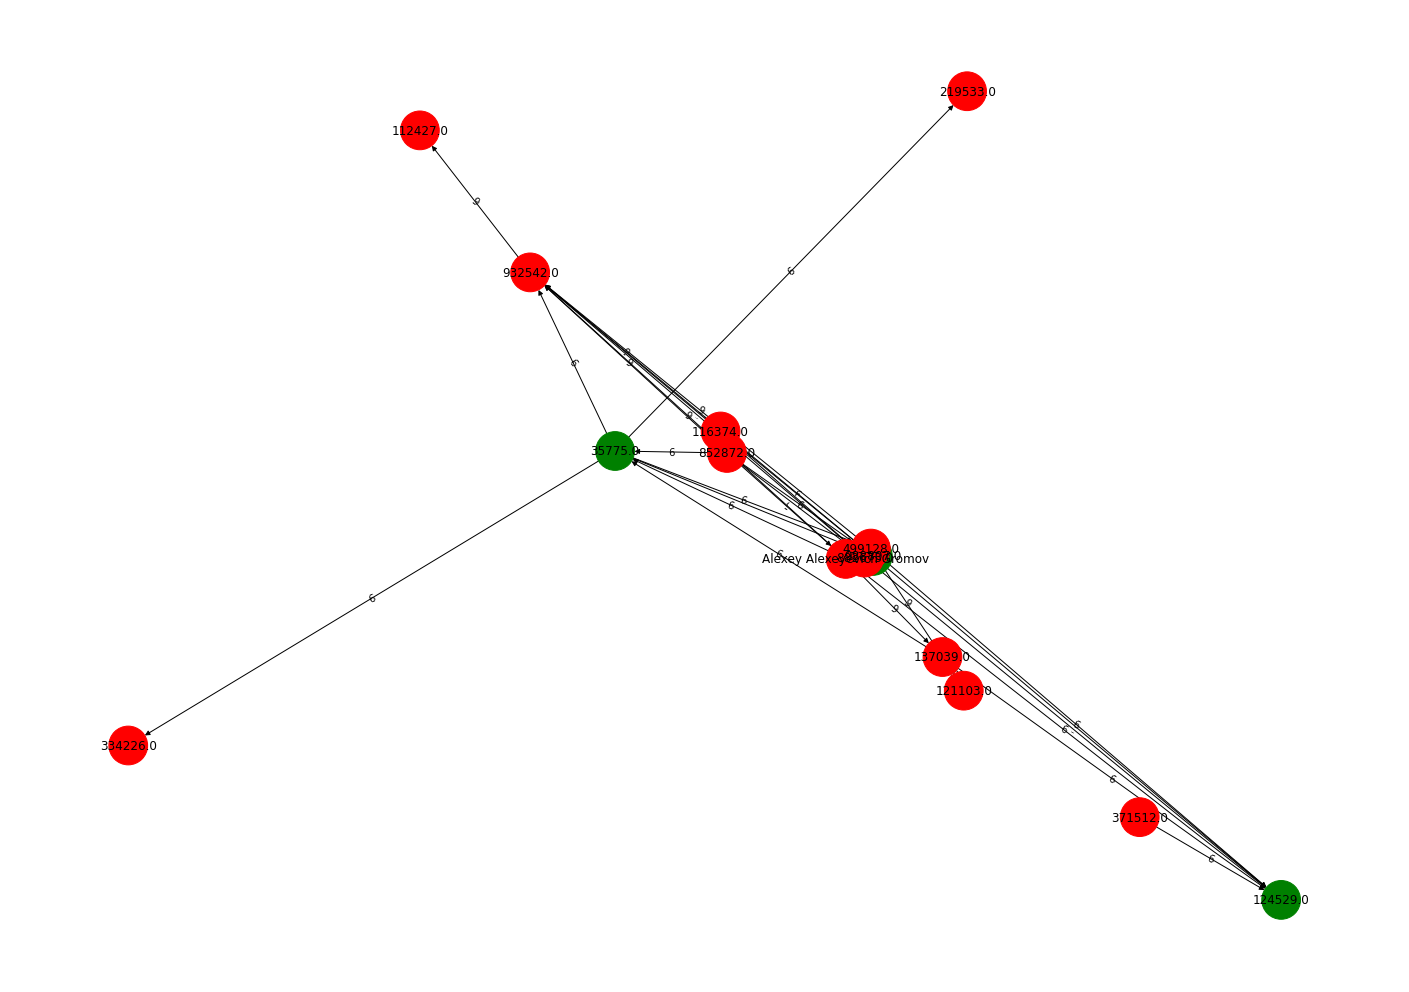

In [ ]:
# riskname = ['Alison Merrilla Redford']
riskname = ['Alexey Alexeyevich Gromov']
# riskname = ['O Jong Gil']
mode = ''
plotConnected(ee, node, mode, riskname, layer = 2)

**Unsupervised Learning**

In [23]:
# name_rule = dict(zip(bad.CUSTOMER_ID, bad.NAME))
# risk = node[(node.NAME.isin(badactor))].CUSTOMER_ID.tolist()
# riskname = node[(node.NAME.isin(badactor))].NAME.tolist()
# ee = edge.groupby(by = ['source', 'target']).sum()
# ee = ee.reset_index()
# ee
edge

,source,target,emt
0,983859.0,544485.0,503.807815
1,605618.0,362627.0,5157.568486
2,323189.0,118238.0,498.628481
3,919153.0,983859.0,401.962668
4,995748.0,983859.0,5095.458776
...,...,...,...
466228,743092.0,307628.0,2959.506391
466229,420266.0,489593.0,208.011081
466230,441447.0,877470.0,2221.199295
466231,444883.0,137297.0,1175.932049


In [24]:
ee0 = edge.copy()#groupby(by = ['source', 'target']).sum()
ee0 = ee0.reset_index()
EE2 = ee0.replace({"source" : name_rule,
                    'target' : name_rule})
EE2#.emt.describe()

,index,source,target,emt
0,0,983859.0,544485.0,503.807815
1,1,605618.0,362627.0,5157.568486
2,2,323189.0,118238.0,498.628481
3,3,919153.0,983859.0,401.962668
4,4,995748.0,983859.0,5095.458776
...,...,...,...,...
466228,466228,743092.0,307628.0,2959.506391
466229,466229,420266.0,489593.0,208.011081
466230,466230,441447.0,877470.0,2221.199295
466231,466231,444883.0,137297.0,1175.932049


In [25]:
'''
regularID2 contains all rows with transactional data related to badactors
'''
# na1 = 'Yon Jun Jo'
# re1 = 344527.0
# regularname = [na1]
D0 = 1
tlist = []
regularname = badactor.copy()
while D0 != 0 :
    regularID2 = EE2[(EE2.target.isin(regularname) == True) | (EE2.source.isin(regularname) == True)]
    nrows = regularID2.shape[0]
    name_1 = regularID2.source.unique().tolist()
    name_2 = regularID2.target.unique().tolist()
    regularname = list(set(name_1).union(set(name_2)))
    regularID2 = EE2[(EE2.target.isin(regularname) == True) | (EE2.source.isin(regularname) == True)]
    D0 = regularID2.shape[0] - nrows
    # print(f'Table From {nrows} rows to {regularID2.shape[0]}, change {D0}')
# tlist.append(regularID2.shape[0])
# regularID[(regularID.source == na1) | (regularID.target == re1)]
regularID2

,index,source,target,emt
117,117,214538.0,547346.0,401.545887
118,118,988825.0,687198.0,308.669309
119,119,898982.0,508159.0,168.567691
120,120,344527.0,547346.0,405.763909
121,121,225525.0,344527.0,399.961885
...,...,...,...,...
448207,448207,494989.0,179095.0,1006.411045
448208,448208,Andrew ira,822216.0,99.637026
448209,448209,822216.0,179095.0,93.836275
448210,448210,179095.0,792137.0,157.985274


In [26]:
'''
Get regular name without badactor
'''
regularID = EE2[(EE2.target.isin(badactor) == False) & (EE2.source.isin(badactor) == False)]
unregularID = EE2[EE2.target.isin(badactor)]
#.groupby(by = ['source', 'target']).count().describe()
name_1 = regularID.source.unique().tolist()
name_2 = regularID.target.unique().tolist()
regularName = list(set(name_1).union(set(name_2)))
len(regularName)

361136

In [31]:
regularID6 = regularID2[(regularID2.target.isin(badactor) == False) & (regularID2.source.isin(badactor) == False)]
unregularID6 = regularID2[regularID2.target.isin(badactor)]
#.groupby(by = ['source', 'target']).count().describe()
name_1 = regularID6.source.unique().tolist()
name_2 = regularID6.target.unique().tolist()
regularName2 = list(set(name_1).union(set(name_2)))
len(regularName2)

397

In [89]:
'''
First we need to remove all unnecessary transactional data, keep transactional data with connection to bad actors
'''
# regularname = badactor.copy()
# na1 = 'Yon Jun Jo'
# re1 = 344527.0

regular_list = []
for rel in tqdm(range(len(regularName2))) :
    regularname = [regularName2[rel]]
#     print(regularname)
    D0 = 1
    tlist = []
    while D0 != 0 :
        regularID = regularID2[(regularID2.target.isin(regularname) == True) | (regularID2.source.isin(regularname) == True)]
        nrows = regularID.shape[0]
        name_1 = regularID.source.unique().tolist()
        name_2 = regularID.target.unique().tolist()
        regularname = list(set(name_1).union(set(name_2)))
        regularID = regularID2[(regularID2.target.isin(regularname) == True) | (regularID2.source.isin(regularname) == True)]
        D0 = regularID.shape[0] - nrows
        # print(f'Table From {nrows} rows to {regularID.shape[0]}, change {D0}')
    for b in badactor :
        temp = regularID[(regularID.target.isin(badactor) == True) | (regularID.source.isin(badactor) == True)]
        score = temp.isin([b]).sum().tolist()
#         print(score)
        if sum(score) == 0 :
            tlist.append(0)
        else :
            tlist.append(sum(score))
#     print(len(tlist))
    regular_list.append(tlist)
#     break

    

100%|██████████| 397/397 [00:14<00:00, 26.53it/s]


In [65]:
# tlist

In [90]:
# temp = regularID[(regularID.target.isin(badactor) == True) | (regularID.source.isin(badactor) == True)]
# sum(temp.isin(['Smirnova, Natalia']).sum().tolist())
# for i in regular_list :
#     print(sum(i))
connectiontable = pd.DataFrame(regular_list, columns = badactor, index = regularName2)
connectiontable

,Yon Jun Jo,"Harrell, Ryan Matson Johnson",Tetiana Viktorivna Pereverzeva,Rakhim Azizboevich Azimov,Kay Williams,O Jong Gil,"Gillette, Maria","Hlaing, Min Aung",Alison Merrilla Redford,Jose Benito Cabrera Cuevas,...,Andrew ira,Viktoria Rodina,"Mazhuga, Aleksandr G.",Michael Harris,Margaret Smith,Chandra Hernandez,Alexander Pealer,Maria Bono Mack,David Guidi,Samantha Lewthwaite
440322.0,0,0,0,0,0,0,0,0,13,0,...,0,0,0,0,0,0,0,0,0,0
788486.0,0,0,0,0,0,0,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0
815111.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174096.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
276498.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235481.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
585690.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
436195.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
862181.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0


In [111]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [112]:
pca_breast = PCA(n_components=3)
connectiontable2 = pca_breast.fit_transform(connectiontable)

In [114]:
connectiontable2 = pd.DataFrame(connectiontable2, columns = ['PC1', 'PC2', 'PC3'], index = regularName2)
connectiontable2

,PC1,PC2,PC3
440322.0,15.449665,0.069671,0.005557
788486.0,-9.061486,-1.177125,-0.297497
815111.0,-9.018693,-1.117324,-0.255778
174096.0,-9.340793,-1.776219,10.664950
276498.0,-9.316032,-1.701546,-4.898040
...,...,...,...
235481.0,-9.153762,-1.328146,-0.455257
585690.0,-8.983951,-1.072699,-0.229431
436195.0,-9.028830,-1.130984,-0.264599
862181.0,-8.985865,-1.075074,-0.230745


In [134]:
resulttable = connectiontable.copy()
kmeans = KMeans(random_state=0, n_init="auto", n_clusters = 3).fit(connectiontable)
resulttable['Class'] = kmeans.labels_

In [121]:
# connectiontable2
resulttable2 = connectiontable2.copy()
kmeans2 = KMeans(random_state=0, n_init="auto", n_clusters = 3).fit(connectiontable2)
resulttable2['Class'] = kmeans2.labels_

In [137]:
resulttable.Class.value_counts()

0    234
1    148
2     15
Name: Class, dtype: int64

In [141]:
resulttable.loc[resulttable2[resulttable2.Class == 2].index]

,Yon Jun Jo,"Harrell, Ryan Matson Johnson",Tetiana Viktorivna Pereverzeva,Rakhim Azizboevich Azimov,Kay Williams,O Jong Gil,"Gillette, Maria","Hlaing, Min Aung",Alison Merrilla Redford,Jose Benito Cabrera Cuevas,...,Viktoria Rodina,"Mazhuga, Aleksandr G.",Michael Harris,Margaret Smith,Chandra Hernandez,Alexander Pealer,Maria Bono Mack,David Guidi,Samantha Lewthwaite,Class
225525.0,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
508159.0,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
344527.0,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47584.0,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
547346.0,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45707.0,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
774930.0,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
687198.0,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
580800.0,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
974084.0,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


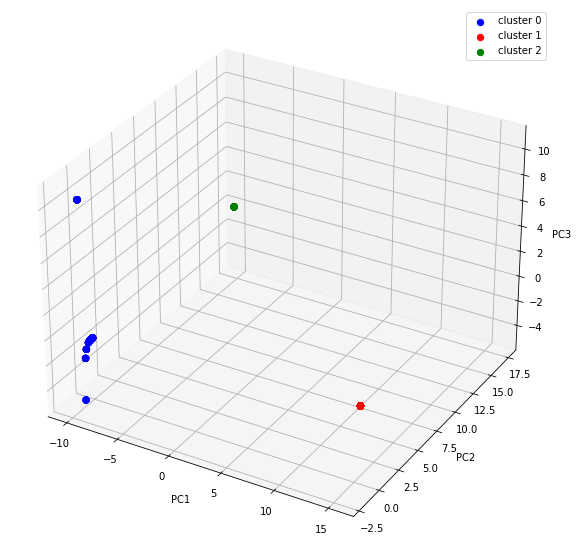

In [126]:
# fig = plt.figure(figsize = (8 * 2, 5 * 2))
# sns.axes_style("darkgrid")
# sns.scatterplot(data=resulttable2[(resulttable2.PC1 < 5) & (resulttable2.PC2 < 5)], 
#                 x="PC2", y="PC2", hue = 'Class', style="Class")
fig = plt.figure(figsize = (8 * 2, 5 * 2))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(resulttable2[resulttable2.Class == 0]['PC1'],
           resulttable2[resulttable2.Class == 0]['PC2'],
           resulttable2[resulttable2.Class == 0]['PC3'], 
           s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(resulttable2[resulttable2.Class == 1]['PC1'],
           resulttable2[resulttable2.Class == 1]['PC2'],
           resulttable2[resulttable2.Class == 1]['PC3'], 
           s = 40 , color = 'red', label = "cluster 1")
ax.scatter(resulttable2[resulttable2.Class == 2]['PC1'],
           resulttable2[resulttable2.Class == 2]['PC2'],
           resulttable2[resulttable2.Class == 2]['PC3'], 
           s = 40 , color = 'green', label = "cluster 2")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
# plt.show()
# 
# x = np.array(resulttable2['PC1'])
# y = np.array(resulttable2['PC2'])
# z = np.array(resulttable2['PC3'])

# ax.scatter(x, y, z, marker="s", c=resulttable2["Class"], s=40, cmap="RdBu")

plt.show()